This notebook draws the nucleosome map of all of our pull-downs using the standard colour palette.


In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('talk')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as OUTPUT_DIRECTORY_MAIN

OUTPUT_DIRECTORY = os.path.join(OUTPUT_DIRECTORY_MAIN, 'metadata')
if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

OUTPUT_VERTICAL = os.path.join(OUTPUT_DIRECTORY, 'nucleosomes-vertical.pdf')

In [3]:
from snapanalysis.preprocessing.pulldown_metadata import OUTPUT_FILE as META_FILE

In [4]:
with pd.HDFStore(META_FILE, 'r') as store:
    predictors_web = store['/meta/predictors_web']
    color_palette = store['/meta/color_palette']
    
    predictors_categorical = store['/meta/predictors_categorical']
    predictors = store['/meta/predictors']
    names = store['/meta/names_and_types']['Pull-Down name'].apply(lambda x: x.strip())
    
    print('\n'.join(store.keys()))

/meta/color_palette
/meta/coloured_predictors
/meta/coloured_predictors_directionalised
/meta/coloured_predictors_directionalised_with_nulls
/meta/coloured_predictors_with_nulls
/meta/dates
/meta/dna
/meta/names_and_types
/meta/octamers
/meta/octamers_categorical
/meta/predictors
/meta/predictors_categorical
/meta/predictors_categorical_directionalised
/meta/predictors_categorical_directionalised_long
/meta/predictors_web
/meta/predictors_with_redundancy


In [5]:
predictors_order = list(predictors_categorical.columns)
pulldowns_order = list(predictors_categorical.index)

In [6]:
import catheat

In [7]:
predictors_web['predictor'].unique()

array(['H3K9', 'DNA Methylation', 'H3K4', 'H3K27', 'H4K20', 'H3K14',
       'H3K18', 'H3K23', 'H4K16', 'H4K5', 'H4K8', 'H4K12', 'H2A.Z'],
      dtype=object)

In [8]:
color_palette = color_palette.to_dict()


In [9]:
matrix = predictors_web.set_index(['Pull-Down ID', 'predictor'])['predictor_value'].unstack()
matrix = matrix.loc[pulldowns_order, predictors_order]

In [10]:
annotations = matrix.copy()
annotations = annotations.replace('meDNA', 'm5C')
annotations = annotations.replace('H2A.Z', 'yes')

# Vertical

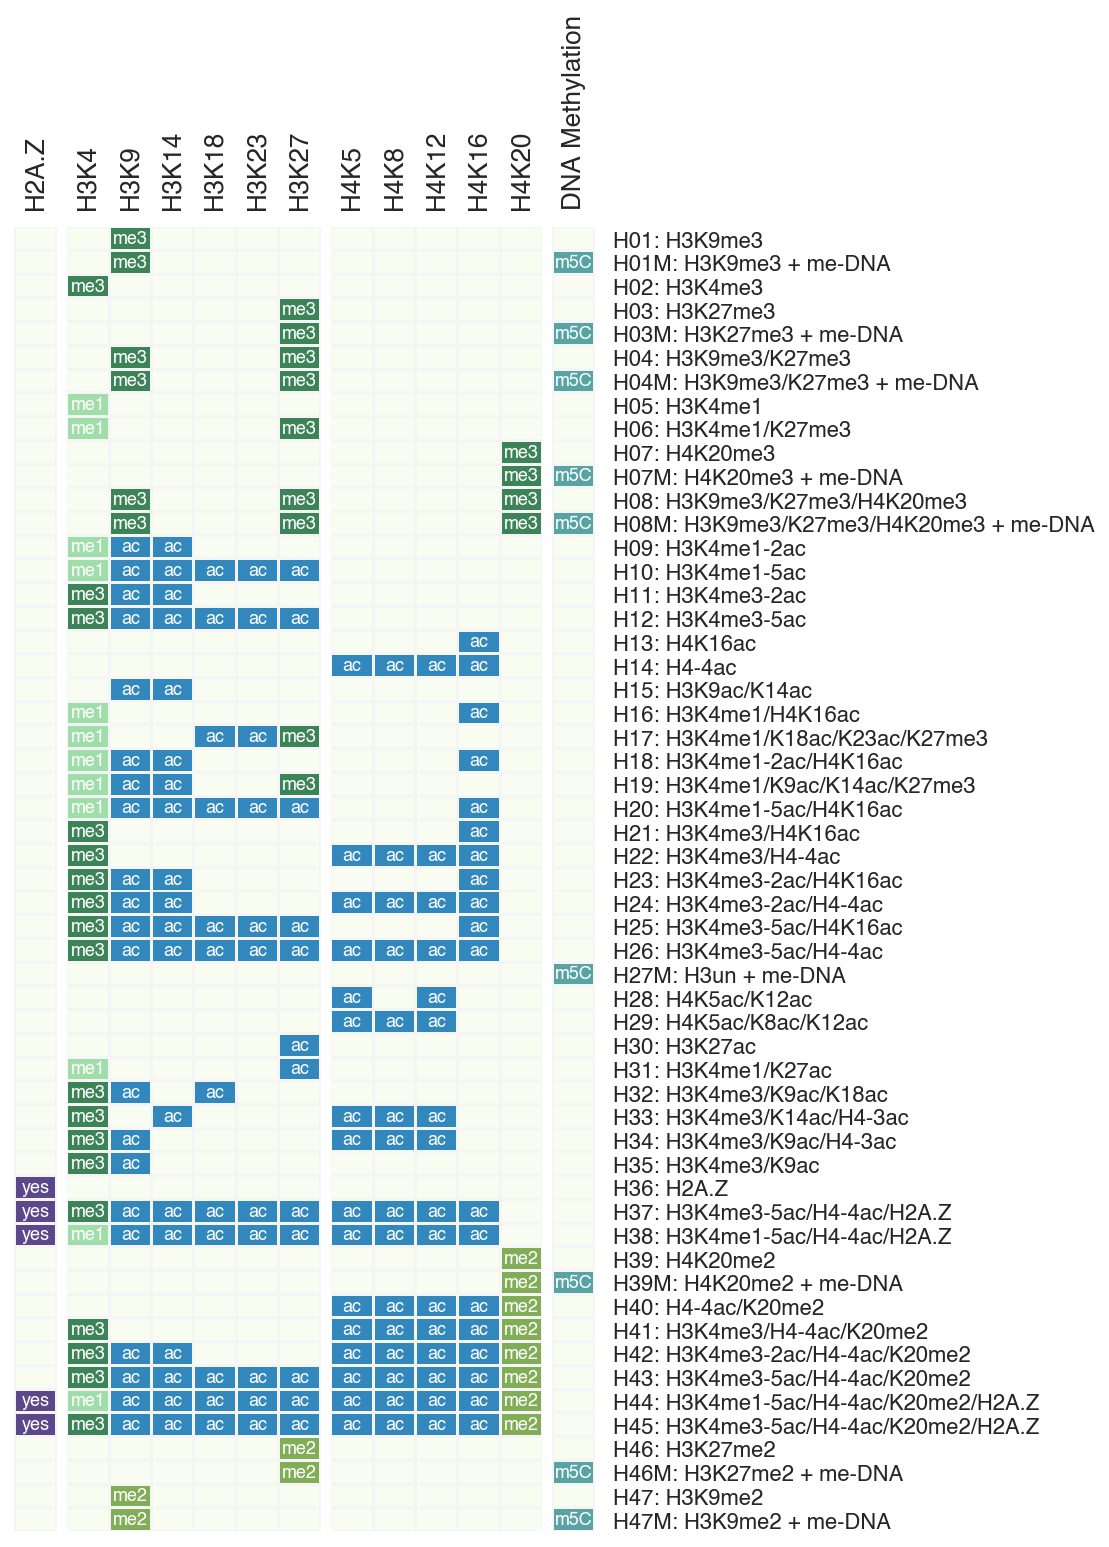

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(5.2, 12))

ax_h3 = plt.gca()
divider = make_axes_locatable(ax_h3)

pad = 0.07
ax_h2az = divider.append_axes("left", size="16.67%", pad=pad)
ax_h4 = divider.append_axes("right", size="83.33%", pad=pad)
ax_dna_me = divider.append_axes("right", size="16.67%", pad=pad)

subsets = [['H2A.Z'], 
           ['H3K4', 'H3K9', 'H3K14', 'H3K18', 'H3K23', 'H3K27'], 
           ['H4K5', 'H4K8', 'H4K12', 'H4K16', 'H4K20'],
           ['DNA Methylation']]

axes = [ax_h2az, ax_h3, ax_h4, ax_dna_me]

labels = ['{}: {}'.format(x, names.loc[x]) for x in matrix.index]

for i, (cols, ax) in enumerate(zip(subsets, axes)):
    catheat.heatmap(matrix[cols], 
                    mask=matrix[cols].isnull(),
                    legend=False,
                    ax=ax,
                    linewidth=1,
                    linecolor='#F5F5F5',
                    annot=annotations[cols],
                    annot_kws=dict(size=9, color='white'),
                    fmt='',
                    yticklabels=labels,
                    cmap=color_palette.copy())
    
    ax.grid(False)
    
    ax.set_facecolor(color_palette['background'])
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    ax.title.set_visible(False)
    
    ax.xaxis.tick_top()
    
    for ticklabel in ax.xaxis.get_ticklabels():
        ticklabel.set_rotation(90)
    
    # Nucleosomes only on the right
    if i == len(axes) - 1:
        ax.yaxis.tick_right()
        for ticklabel in ax.yaxis.get_ticklabels():
            ticklabel.set_rotation(0)
            ticklabel.set_fontsize(11)
    else:
        ax.set_yticks([])
        
    
plt.savefig(OUTPUT_VERTICAL, bbox_inches = 'tight')

# Co-occurence

In [12]:
unsplit_predictors = predictors.copy()

unsplit_predictors['H4K5ac'] = unsplit_predictors['H4K5ac/H4K12ac'].copy()
unsplit_predictors['H4K8ac'] = unsplit_predictors['H4K5ac/H4K12ac'].copy()

del unsplit_predictors['H4K5ac/H4K12ac']

In [13]:
import itertools

cooccurrences = []
coocurrences_ix = []

for predictor_a, predictor_b in itertools.permutations(unsplit_predictors.columns, 2):
    mask_a = unsplit_predictors[predictor_a]
    mask_b = unsplit_predictors[predictor_b]
    
    cooccurrences.append((mask_a & mask_b).sum())
    
    coocurrences_ix.append([predictor_a, predictor_b])

# also fill the diagonal
for predictor_a in unsplit_predictors.columns:
    cooccurrences.append(unsplit_predictors[predictor_a].sum())

    coocurrences_ix.append([predictor_a, predictor_a])

cooccurrences = pd.Series(cooccurrences, 
                          index=pd.MultiIndex.from_tuples(coocurrences_ix, names=['a', 'b']),
                          name='n_cooccurrences')


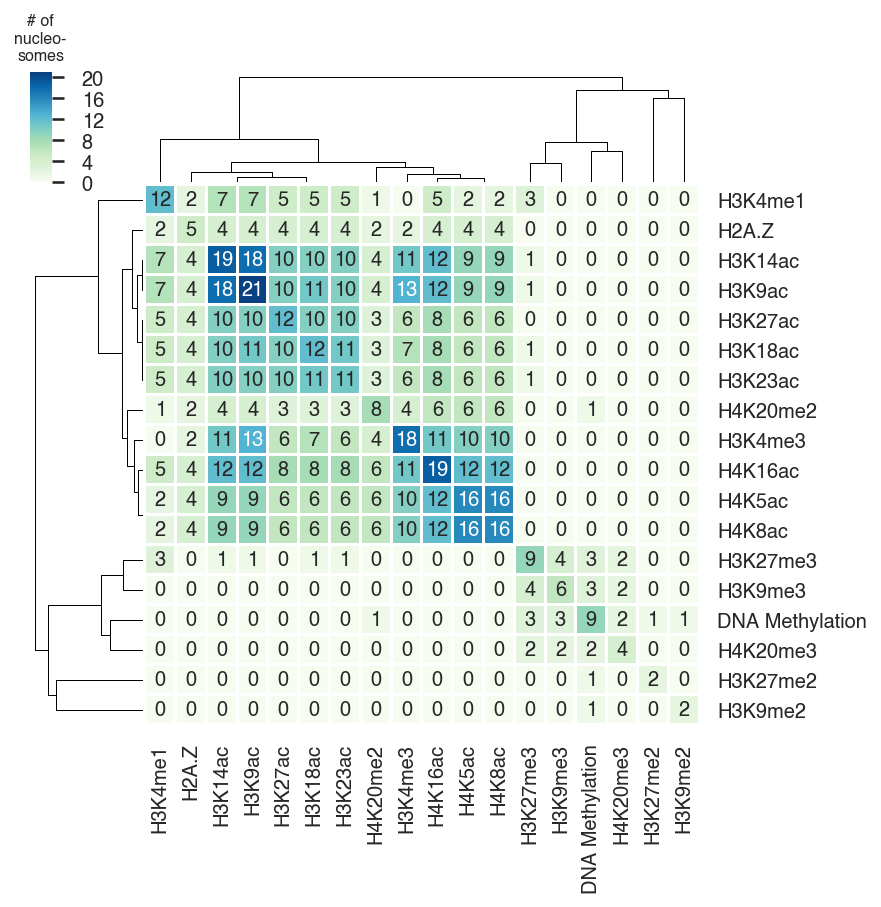

In [15]:
clustermap = sns.clustermap(cooccurrences.unstack('b'), annot=True, cmap='GnBu', 
                            figsize=(6,6), linewidths=1, linecolor='white',
                            annot_kws=dict(size=10),
                            method='complete', metric='cosine')
clustermap.ax_heatmap.set_xlabel('')
clustermap.ax_heatmap.set_ylabel('')

clustermap.ax_heatmap.xaxis.set_tick_params(labelsize=10, length=0)
clustermap.ax_heatmap.yaxis.set_tick_params(labelsize=10, length=0)
clustermap.cax.yaxis.set_tick_params(labelsize=10)
clustermap.cax.set_title('# of\nnucleo-\nsomes', fontsize=8)

clustermap.savefig(os.path.join(OUTPUT_DIRECTORY, 'ptm-co-occurrence.pdf'))